In [8]:
import os
import pathlib
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set image size limit
Image.MAX_IMAGE_PIXELS = 300000000

# Define data paths
ai_path = pathlib.Path("/kaggle/input/dalle-recognition-dataset/fakeV2/fake-v2")
real_path = pathlib.Path("/kaggle/input/dalle-recognition-dataset/real")

# Function to get all valid images from a path
def get_valid_images(path, label):
    images = list(path.rglob("*.jpg")) + list(path.rglob("*.png"))
    valid_paths, valid_labels = [], []

    for img_path in images:
        try:
            with Image.open(img_path) as img:
                img.verify()
                valid_paths.append(str(img_path))
                valid_labels.append(label)
        except:
            continue
    return valid_paths, valid_labels

# Collect valid image paths and labels
ai_images, ai_labels = get_valid_images(ai_path, "AiArt")
real_images, real_labels = get_valid_images(real_path, "RealArt")

# Combine and create dataframe
all_images = ai_images + real_images
all_labels = ai_labels + real_labels

print("Label counts before balancing:", Counter(all_labels))

df = pd.DataFrame({"filename": all_images, "class": all_labels})

# Balance the dataset
min_count = df['class'].value_counts().min()
balanced_df = df.groupby("class").apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)

print("Label counts after balancing:", balanced_df['class'].value_counts())

# Train/Val/Test Split
train_val_df, test_df = train_test_split(balanced_df, test_size=0.10, stratify=balanced_df["class"], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.11, stratify=train_val_df["class"], random_state=42)

print("Train class counts:\n", train_df["class"].value_counts())
print("Val class counts:\n", val_df["class"].value_counts())
print("Test class counts:\n", test_df["class"].value_counts())

# ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Use 'categorical' class_mode for 2+ classes
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)


Label counts before balancing: Counter({'AiArt': 17855, 'RealArt': 3780})
Label counts after balancing: class
AiArt      3780
RealArt    3780
Name: count, dtype: int64
Train class counts:
 class
RealArt    3028
AiArt      3027
Name: count, dtype: int64
Val class counts:
 class
AiArt      375
RealArt    374
Name: count, dtype: int64
Test class counts:
 class
RealArt    378
AiArt      378
Name: count, dtype: int64
Found 6055 validated image filenames belonging to 2 classes.
Found 749 validated image filenames belonging to 2 classes.
Found 756 validated image filenames belonging to 2 classes.


/tmp/ipykernel_36/4088874114.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby("class").apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels
images, labels = next(train_generator)

# Convert one-hot encoded labels to class indices
label_indices = np.argmax(labels, axis=1)

# Get class names
class_names = list(train_generator.class_indices.keys())

# Plot the images
plt.figure(figsize=(15, 15))
for i in range(30):
    ax = plt.subplot(7, 6, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[label_indices[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()


AxisError: axis 1 is out of bounds for array of dimension 1

AI Art Images: 17855
Real Art Images: 3780


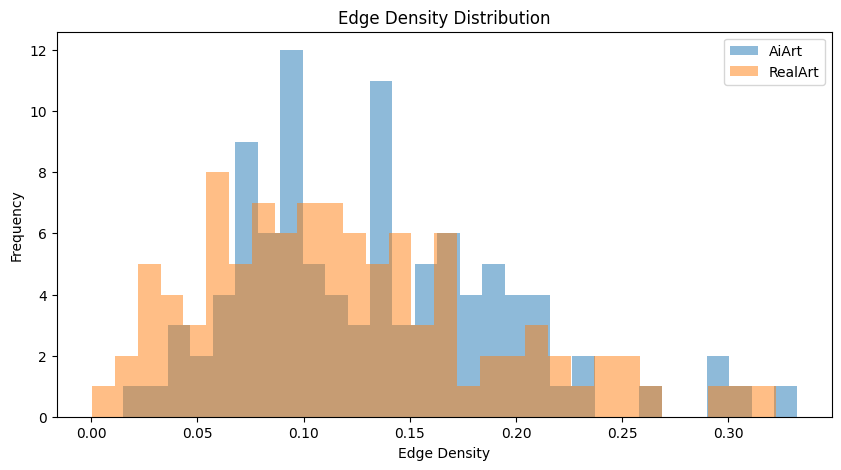

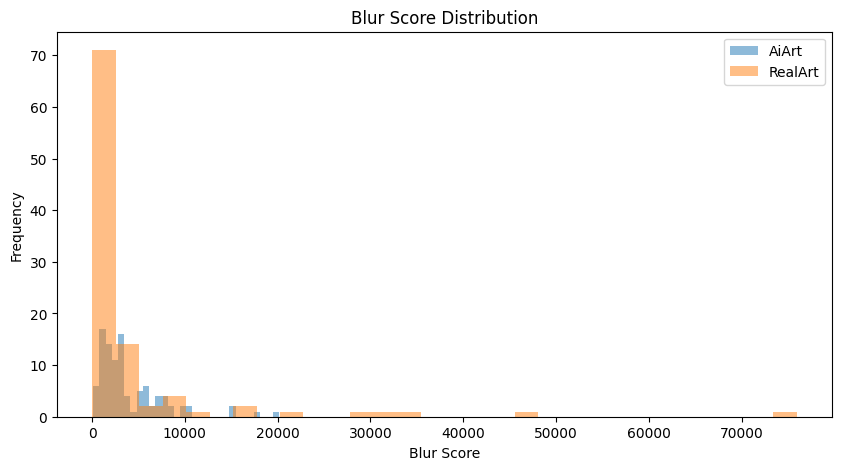

In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from pathlib import Path

# Correct dataset paths
aiart_dir = Path("/kaggle/input/dalle-recognition-dataset/fakeV2/fake-v2")
realart_dir = Path("/kaggle/input/dalle-recognition-dataset/real")

# Collect images
aiart_images = list(aiart_dir.glob("*.jpg")) + list(aiart_dir.glob("*.png"))
realart_images = list(realart_dir.glob("*.jpg")) + list(realart_dir.glob("*.png"))

print(f"AI Art Images: {len(aiart_images)}")
print(f"Real Art Images: {len(realart_images)}")

# Create DataFrame
image_paths = [str(path) for path in aiart_images + realart_images]
labels = ["AiArt"] * len(aiart_images) + ["RealArt"] * len(realart_images)
data = pd.DataFrame({"filename": image_paths, "class": labels})

# If not enough images, adjust the sample size
min_class_size = min(data["class"].value_counts().values)
sample_size = min(100, min_class_size)

# Sample evenly
sampled_data = pd.concat([
    data[data["class"] == "AiArt"].sample(sample_size, random_state=42),
    data[data["class"] == "RealArt"].sample(sample_size, random_state=42)
])

# Metric: Edge density
def compute_edge_density(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return 0
    img = cv2.resize(img, (224, 224))
    edges = cv2.Canny(img, 100, 200)
    return np.sum(edges > 0) / (224 * 224)

# Metric: Blur score
def blur_score(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return 0
    img = cv2.resize(img, (224, 224))
    return cv2.Laplacian(img, cv2.CV_64F).var()

# Compute metrics
sampled_data["edge_density"] = sampled_data["filename"].apply(compute_edge_density)
sampled_data["blur_score"] = sampled_data["filename"].apply(blur_score)

# Visualization: Edge Density
plt.figure(figsize=(10, 5))
for cls in ["AiArt", "RealArt"]:
    plt.hist(sampled_data[sampled_data["class"] == cls]["edge_density"], bins=30, alpha=0.5, label=cls)
plt.xlabel("Edge Density")
plt.ylabel("Frequency")
plt.title("Edge Density Distribution")
plt.legend()
plt.show()

# Visualization: Blur Score
plt.figure(figsize=(10, 5))
for cls in ["AiArt", "RealArt"]:
    plt.hist(sampled_data[sampled_data["class"] == cls]["blur_score"], bins=30, alpha=0.5, label=cls)
plt.xlabel("Blur Score")
plt.ylabel("Frequency")
plt.title("Blur Score Distribution")
plt.legend()
plt.show()


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input

def create_custom_cnn(input_shape=(224, 224, 3)):
    model = Sequential()

    # Block 1
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Block 2
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    # Block 3
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    # Classification head
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    return model


In [13]:
model = create_custom_cnn()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,225 (1.13 MB)

 Trainable params: 295,777 (1.13 MB)

 Non-trainable params: 448 (1.75 KB)

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ModelCheckpoint("best_custom_cnn.h5", save_best_only=True)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1753256444.386418     103 service.cc:148] XLA service 0x78ff8c060520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753256444.387537     103 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753256445.007199     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/190 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.5625 - loss: 0.8653 

I0000 00:00:1753256455.247013     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 54/190 ━━━━━━━━━━━━━━━━━━━━ 2:07 940ms/step - accuracy: 0.5884 - loss: 0.7829

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


190/190 ━━━━━━━━━━━━━━━━━━━━ 203s 981ms/step - accuracy: 0.6387 - loss: 0.6903 - val_accuracy: 0.4993 - val_loss: 1.3877 - learning_rate: 0.0010
Epoch 2/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 171s 903ms/step - accuracy: 0.7726 - loss: 0.4893 - val_accuracy: 0.5007 - val_loss: 1.4739 - learning_rate: 0.0010
Epoch 3/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 171s 897ms/step - accuracy: 0.8065 - loss: 0.4391 - val_accuracy: 0.6235 - val_loss: 0.9104 - learning_rate: 0.0010
Epoch 4/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 174s 918ms/step - accuracy: 0.8279 - loss: 0.4122 - val_accuracy: 0.8451 - val_loss: 0.3777 - learning_rate: 0.0010
Epoch 5/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 175s 921ms/step - accuracy: 0.8321 - loss: 0.4035 - val_accuracy: 0.8144 - val_loss: 0.3977 - learning_rate: 0.0010
Epoch 6/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 179s 941ms/step - accuracy: 0.8365 - loss: 0.3892 - val_accuracy: 0.8558 - val_loss: 0.3366 - learning_rate: 0.0010
Epoch 7/30
190/190 ━━━━━━━━━━━━━━━━━━━━ 179s 939ms/step - accuracy: 0.8452 

In [16]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")


24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 506ms/step - accuracy: 0.8764 - loss: 0.2803
Test Accuracy: 88.76%


24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 544ms/step


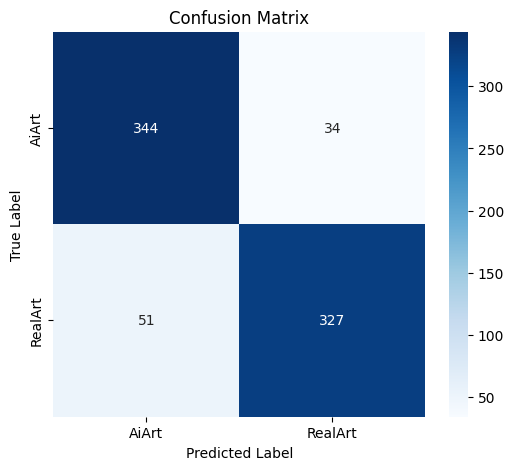


Classification Report:
              precision    recall  f1-score   support

       AiArt       0.87      0.91      0.89       378
     RealArt       0.91      0.87      0.88       378

    accuracy                           0.89       756
   macro avg       0.89      0.89      0.89       756
weighted avg       0.89      0.89      0.89       756



In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predict on test set
test_generator.reset()
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()  # binary prediction

# True labels
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Optional: Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


In [19]:
import tensorflow as tf
import cv2

def get_gradcam(model, image_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([image_array]))
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(image_path, model, last_conv_layer_name='conv2d_4', preprocess_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=preprocess_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0

    heatmap = get_gradcam(model, img_array, last_conv_layer_name)

    # Load original image for overlay
    img_original = cv2.imread(image_path)
    img_original = cv2.resize(img_original, preprocess_size)
    heatmap_resized = cv2.resize(heatmap, (img_original.shape[1], img_original.shape[0]))

    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = heatmap_colored * 0.4 + img_original

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_original[:, :, ::-1])
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img[:, :, ::-1])
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
